# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from scipy.stats import skew
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
#azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
#mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
#mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [4]:
# pickle dataframes to speed-up data loading next time
#azdias.to_pickle('azdias.pkl')
#customers.to_pickle('customers.pkl')
#mailout_train.to_pickle('mailout_train.pkl')
#mailout_test.to_pickle('mailout_test.pkl')

In [5]:
# read in from pickle files
azdias = pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

## Data Exploration and Visualization

In [6]:
# Shape of the general population dataset
azdias.shape

(891221, 366)

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
# Shape of the customers dataset
customers.shape

(191652, 369)

In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
# Column differences between the datasets
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [11]:
# Describe the general population dataset
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [12]:
# Describe the customers dataset
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [13]:
# Manually create set of attributes and their "unknown" values to turn into Nan values
unknown_values = {'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KBA05_GBZ': [-1, 0],
 'KBA05_HERST1': [-1, 9],
 'KBA05_HERST2': [-1, 9],
 'KBA05_HERST3': [-1, 9],
 'KBA05_HERST4': [-1, 9],
 'KBA05_HERST5': [-1, 9],
 'KBA05_HERSTTEMP': [-1, 9],
 'KBA05_KRSAQUOT': [-1, 9],
 'KBA05_KRSHERST1': [-1, 9],
 'KBA05_KRSHERST2': [-1, 9],
 'KBA05_KRSHERST3': [-1, 9],
 'KBA05_KRSKLEIN': [-1, 9],
 'KBA05_KRSOBER': [-1, 9],
 'KBA05_KRSVAN': [-1, 9],
 'KBA05_KRSZUL': [-1, 9],
 'KBA05_KW1': [-1, 9],
 'KBA05_KW2': [-1, 9],
 'KBA05_KW3': [-1, 9],
 'KBA05_MAXAH': [-1, 9],
 'KBA05_MAXBJ': [-1, 9],
 'KBA05_MAXHERST': [-1, 9],
 'KBA05_MAXSEG': [-1, 9],
 'KBA05_MAXVORB': [-1, 9],
 'KBA05_MOD1': [-1, 9],
 'KBA05_MOD2': [-1, 9],
 'KBA05_MOD3': [-1, 9],
 'KBA05_MOD4': [-1, 9],
 'KBA05_MOD8': [-1, 9],
 'KBA05_MODTEMP': [-1, 9],
 'KBA05_MOTOR': [-1, 9],
 'KBA05_MOTRAD': [-1, 9],
 'KBA05_SEG1': [-1, 9],
 'KBA05_SEG10': [-1, 9],
 'KBA05_SEG2': [-1, 9],
 'KBA05_SEG3': [-1, 9],
 'KBA05_SEG4': [-1, 9],
 'KBA05_SEG5': [-1, 9],
 'KBA05_SEG6': [-1, 9],
 'KBA05_SEG7': [-1, 9],
 'KBA05_SEG8': [-1, 9],
 'KBA05_SEG9': [-1, 9],
 'KBA05_VORB0': [-1, 9],
 'KBA05_VORB1': [-1, 9],
 'KBA05_VORB2': [-1, 9],
 'KBA05_ZUL1': [-1, 9],
 'KBA05_ZUL2': [-1, 9],
 'KBA05_ZUL3': [-1, 9],
 'KBA05_ZUL4': [-1, 9],
 'KBA13_ALTERHALTER_30': [-1],
 'KBA13_ALTERHALTER_45': [-1],
 'KBA13_ALTERHALTER_60': [-1],
 'KBA13_ALTERHALTER_61': [-1],
 'KBA13_AUDI': [-1],
 'KBA13_AUTOQUOTE': [-1],
 'KBA13_BJ_1999': [-1],
 'KBA13_BJ_2000': [-1],
 'KBA13_BJ_2004': [-1],
 'KBA13_BJ_2006': [-1],
 'KBA13_BJ_2008': [-1],
 'KBA13_BJ_2009': [-1],
 'KBA13_BMW': [-1],
 'KBA13_CCM_1000': [-1],
 'KBA13_CCM_1200': [-1],
 'KBA13_CCM_1400': [-1],
 'KBA13_CCM_0_1400': [-1],
 'KBA13_CCM_1500': [-1],
 'KBA13_CCM_1400_2500': [-1],
 'KBA13_CCM_1600': [-1],
 'KBA13_CCM_1800': [-1],
 'KBA13_CCM_2000': [-1],
 'KBA13_CCM_2500': [-1],
 'KBA13_CCM_2501': [-1],
 'KBA13_CCM_3000': [-1],
 'KBA13_CCM_3001': [-1],
 'KBA13_FAB_ASIEN': [-1],
 'KBA13_FAB_SONSTIGE': [-1],
 'KBA13_FIAT': [-1],
 'KBA13_FORD': [-1],
 'KBA13_HALTER_20': [-1],
 'KBA13_HALTER_25': [-1],
 'KBA13_HALTER_30': [-1],
 'KBA13_HALTER_35': [-1],
 'KBA13_HALTER_40': [-1],
 'KBA13_HALTER_45': [-1],
 'KBA13_HALTER_50': [-1],
 'KBA13_HALTER_55': [-1],
 'KBA13_HALTER_60': [-1],
 'KBA13_HALTER_65': [-1],
 'KBA13_HALTER_66': [-1],
 'KBA13_HERST_ASIEN': [-1],
 'KBA13_HERST_AUDI_VW': [-1],
 'KBA13_HERST_BMW_BENZ': [-1],
 'KBA13_HERST_EUROPA': [-1],
 'KBA13_HERST_FORD_OPEL': [-1],
 'KBA13_HERST_SONST': [-1],
 'KBA13_KMH_110': [-1],
 'KBA13_KMH_140': [-1],
 'KBA13_KMH_180': [-1],
 'KBA13_KMH_0_140': [-1],
 'KBA13_KMH_140_210': [-1],
 'KBA13_KMH_211': [-1],
 'KBA13_KMH_250': [-1],
 'KBA13_KMH_251': [-1],
 'KBA13_KRSAQUOT': [-1],
 'KBA13_KRSHERST_AUDI_VW': [-1],
 'KBA13_KRSHERST_BMW_BENZ': [-1],
 'KBA13_KRSHERST_FORD_OPEL': [-1],
 'KBA13_KRSSEG_KLEIN': [-1],
 'KBA13_KRSSEG_OBER': [-1],
 'KBA13_KRSSEG_VAN': [-1],
 'KBA13_KRSZUL_NEU': [-1],
 'KBA13_KW_30': [-1],
 'KBA13_KW_40': [-1],
 'KBA13_KW_50': [-1],
 'KBA13_KW_60': [-1],
 'KBA13_KW_0_60': [-1],
 'KBA13_KW_70': [-1],
 'KBA13_KW_61_120': [-1],
 'KBA13_KW_80': [-1],
 'KBA13_KW_90': [-1],
 'KBA13_KW_110': [-1],
 'KBA13_KW_120': [-1],
 'KBA13_KW_121': [-1],
 'KBA13_MAZDA': [-1],
 'KBA13_MERCEDES': [-1],
 'KBA13_MOTOR': [-1],
 'KBA13_NISSAN': [-1],
 'KBA13_OPEL': [-1],
 'KBA13_PEUGEOT': [-1],
 'KBA13_RENAULT': [-1],
 'KBA13_SEG_GELAENDEWAGEN': [-1],
 'KBA13_SEG_GROSSRAUMVANS': [-1],
 'KBA13_SEG_KLEINST': [-1],
 'KBA13_SEG_KLEINWAGEN': [-1],
 'KBA13_SEG_KOMPAKTKLASSE': [-1],
 'KBA13_SEG_MINIVANS': [-1],
 'KBA13_SEG_MINIWAGEN': [-1],
 'KBA13_SEG_MITTELKLASSE': [-1],
 'KBA13_SEG_OBEREMITTELKLASSE': [-1],
 'KBA13_SEG_OBERKLASSE': [-1],
 'KBA13_SEG_SONSTIGE': [-1],
 'KBA13_SEG_SPORTWAGEN': [-1],
 'KBA13_SEG_UTILITIES': [-1],
 'KBA13_SEG_VAN': [-1],
 'KBA13_SEG_WOHNMOBILE': [-1],
 'KBA13_SITZE_4': [-1],
 'KBA13_SITZE_5': [-1],
 'KBA13_SITZE_6': [-1],
 'KBA13_TOYOTA': [-1],
 'KBA13_VORB_0': [-1],
 'KBA13_VORB_1': [-1],
 'KBA13_VORB_1_2': [-1],
 'KBA13_VORB_2': [-1],
 'KBA13_VORB_3': [-1],
 'KBA13_VW': [-1],
 'KKK': [-1, 0],
 'NATIONALITAET_KZ': [-1, 0],
 'ORTSGR_KLS9': [-1],
 'OST_WEST_KZ': [-1],
 'PLZ8_ANTG1': [-1],
 'PLZ8_ANTG2': [-1],
 'PLZ8_ANTG3': [-1],
 'PLZ8_ANTG4': [-1],
 'PLZ8_GBZ': [-1],
 'PLZ8_HHZ': [-1],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'REGIOTYP': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_FLAG': [-1],
 'TITEL_KZ': [-1, 0],
 'VERS_TYP': [-1],
 'WOHNDAUER_2008': [-1, 0],
 'WOHNLAGE': [-1],
 'WACHSTUMSGEBIET_NB': [-1, 0],
 'W_KEIT_KIND_HH': [-1, 0],
 'ZABEOTYP': [-1, 9]}

In [14]:
# Convert unknown values to NaN in the dataset
for attribute in unknown_values:
    # Verify if the attribute exists in the dataframe
    if attribute in azdias.columns:
        for key in unknown_values[attribute]:
            azdias[attribute].replace(key, np.NaN, inplace=True)

# Calculate the number and percentage of missing values
missing_counts = azdias.isnull().sum()
missing_percentage = missing_counts / len(azdias) * 100



Text(0, 0.5, 'Percent of missing values %')

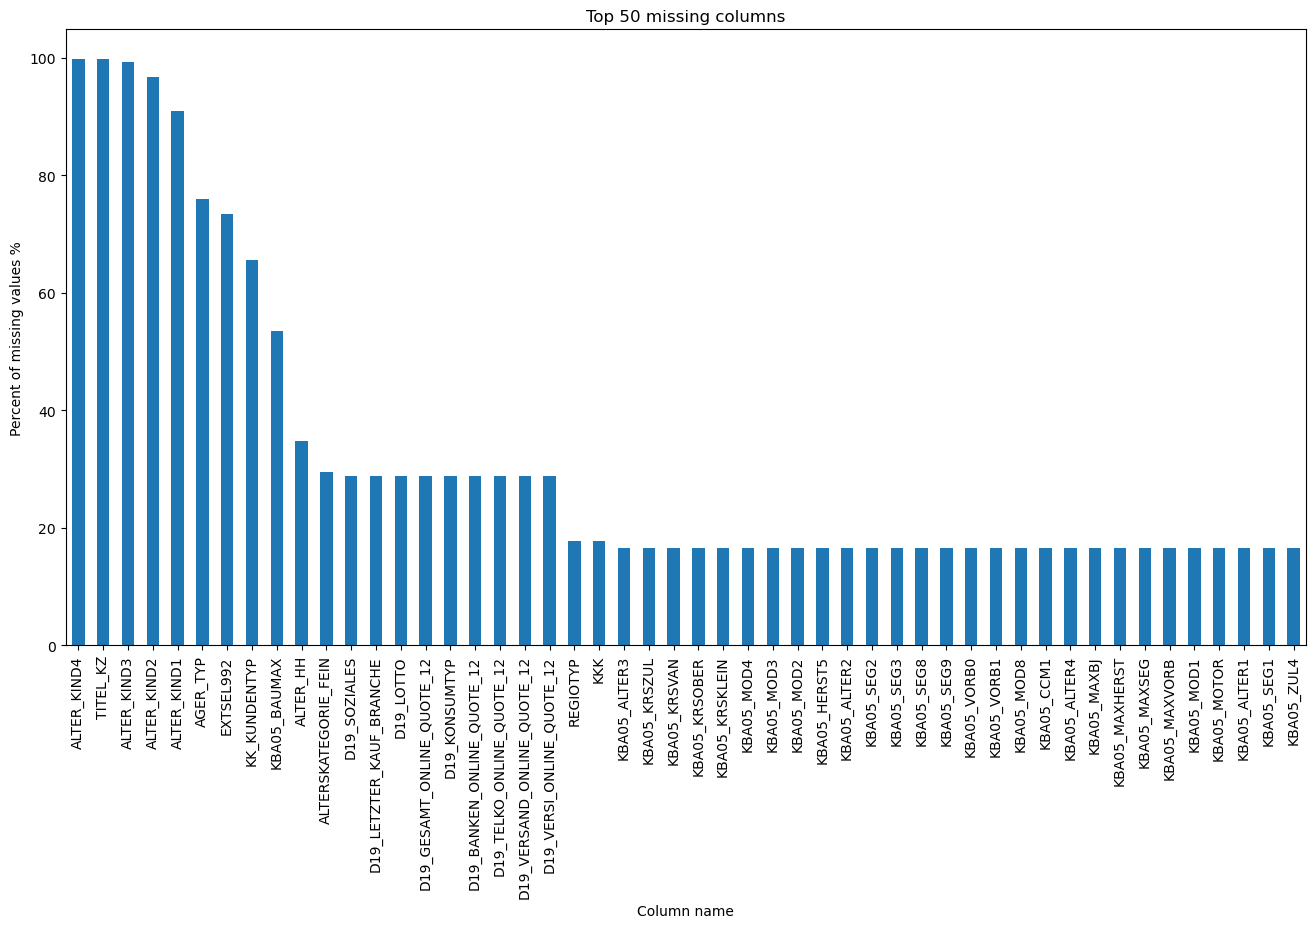

In [16]:
# Visualize the top 50 columns with the highest percentage of missing values
ax = missing_percentage.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(16,8), title='Top 50 Columns with Missing Values')
ax.set_xlabel("Column Name")
ax.set_ylabel("Percentage of Missing Values")

In [17]:
average_missing = round(missing_percentage.mean(), 1)
percentile_97_missing = round(missing_percentage.quantile(0.97), 1)
percentile_98_missing = round(missing_percentage.quantile(0.98), 1)

print(f"On average, columns have {average_missing}% missing data.")
print(f"97% of columns have {percentile_97_missing}% or less missing data.")
print(f"98% of columns have {percentile_98_missing}% or less missing data.")

On average, columns have 11.4% of missing data.
97% of columns have 28.9% or less missing data.
98% of columns have 62.0% or less missing data.


There is a jump in the percentage of missing data in the column from 97% of the columns to 98% of the columns. This is a good point at which to drop columns. We could drop all columns that have more than 30% missing data. Looking at the graph of missing data percentages, though, it looks like we should drop columns with more than 40% missing data.

In [18]:
# Identify columns with more than 40% missing values
columns_to_drop = list(missing_percentage[missing_percentage > 40].index)

# Print the number of columns to be dropped and their names
print(f"{len(columns_to_drop)} columns with more than 40% missing values will be dropped: {columns_to_drop}")

9 columns that have more than 40% missing values will be dropped: ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


9 columns that have more than 40% missing values will be dropped: ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']

In [19]:
azdias_clean = azdias.drop(drop_null_cols, axis=1)

In [21]:
azdias_clean['EINGEFUEGT_AM'] = pd.to_datetime(azdias_clean['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S').dt.year

In [22]:
# Convert 'O' to 0 and 'W' to 1 in the 'OST_WEST_KZ' column, then change the column to numeric type
azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
azdias_clean['OST_WEST_KZ'] = pd.to_numeric(azdias_clean['OST_WEST_KZ'], errors='coerce')

#### Rows with missing data

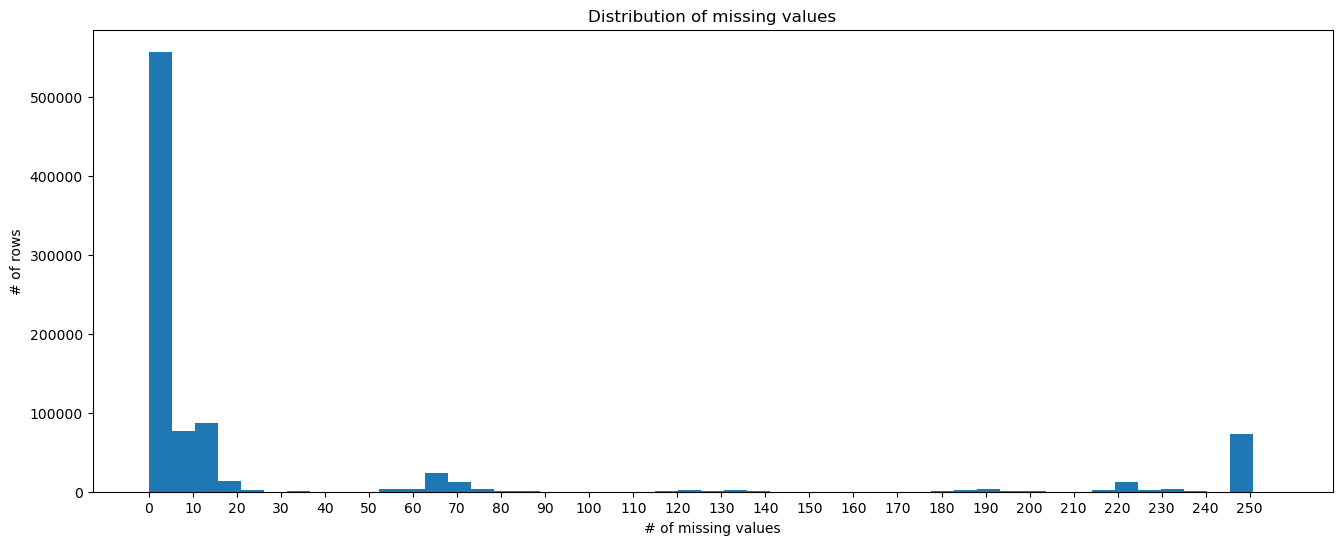

In [23]:
# Visualize the distribution of missing values per row
missing_values_per_row = azdias_clean.isnull().sum(axis=1)

plt.figure(figsize=(16, 6))
plt.hist(missing_values_per_row, bins=np.linspace(missing_values_per_row.min(), missing_values_per_row.max() + 1))

plt.xticks(np.arange(missing_values_per_row.min(), missing_values_per_row.max() + 1, 10))
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.title('Distribution of Missing Values')
plt.show()

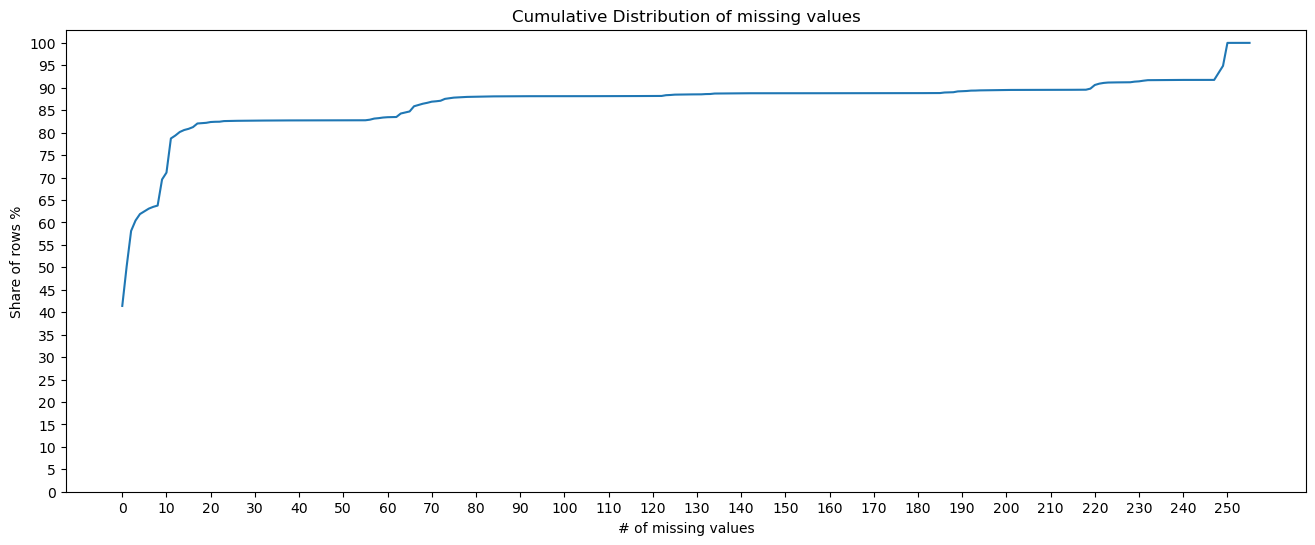

In [24]:
# Calculate the cumulative distribution of missing values per row
cumulative_missing_values = (azdias_clean.isnull().sum(axis=1).value_counts().sort_index().cumsum() / len(azdias_clean)) * 100

plt.figure(figsize=(16, 6))
plt.plot(cumulative_missing_values)

plt.yticks(np.arange(0, 105, 5))
plt.xticks(np.arange(cumulative_missing_values.index.min(), cumulative_missing_values.index.max() + 1, 10))
plt.ylabel('Percentage of Rows')
plt.xlabel('Number of Missing Values')
plt.title('Cumulative Distribution of Missing Values')
plt.savefig('dist_missing_rows.png', dpi=500)
plt.show()

In [26]:
# Drop all rows with more than 11 values missing
azdias_clean = azdias_clean[azdias_clean.isnull().sum(axis=1) <= 11].reset_index(drop=True)
print('number of rows in new dataset: ',azdias_clean.shape[0])

number of rows in new dataset:  701432


In [27]:
customers_clean = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

In [28]:
customers_clean = customers_clean.drop(drop_null_cols, axis=1)

In [29]:
# Convert 'EINGEFUEGT_AM' to datetime and extract the year
customers_clean['EINGEFUEGT_AM'] = pd.to_datetime(customers_clean['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S').dt.year

# Replace 'O' with 0 and 'W' with 1 in the 'OST_WEST_KZ' column
customers_clean['OST_WEST_KZ'] = customers_clean['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
customers_clean['OST_WEST_KZ'] = pd.to_numeric(customers_clean['OST_WEST_KZ'], errors='coerce')

# Remove rows with more than 11 missing values and reset the index
customers_clean = customers_clean[customers_clean.isnull().sum(axis=1) <= 11].reset_index(drop=True)

# Print the number of rows in the cleaned dataset
print('Number of rows in the cleaned dataset:', customers_clean.shape[0])


number of rows in new dataset:  131987


### Impute, transform, and standardize features

Skewed continuous: Continuous numbers that are highly skewed should be log-transformed first before imputation. Missing values are then median imputed after transformation.

Binary: Missing values will be imputed based on the most common value.

Categorical: Categorical values will be one-hot encoded and then imputed based on the most common value.

Numerical: Missing values will be imputed based on the median value.

##### Skewed Column

In [66]:
# Get the continuous columns manually
continuous_cols = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']

In [67]:
# Identify skewed continuous columns
skewed_columns = [col for col in continuous_cols if abs(skew(azdias_clean[col].dropna())) > 1]

# Define a pipeline for log transformation, imputation, and scaling of skewed columns
skew_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('impute_median', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale_standard', StandardScaler())
])

##### Binary

In [ ]:
# Select numeric columns from the dataset
numeric_columns = azdias_clean.select_dtypes(include=['float64', 'int64']).columns

# Identify binary columns
binary_columns = [col for col in numeric_columns if azdias_clean[col].dropna().nunique() == 2]

# Define a pipeline for imputation of binary columns
binary_pipeline = Pipeline([
    ('impute_most_frequent', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])


##### Categorical

In [71]:
# Identify categorical columns in the dataset
categorical_columns = list(azdias_clean.select_dtypes(include=['object']).columns)

# Define a pipeline for imputation and one-hot encoding of categorical columns
categorical_pipeline = Pipeline([
    ('impute_most_frequent', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot_encode', OneHotEncoder(handle_unknown='ignore'))
])


##### Numerical

In [73]:
# Identify numerical columns excluding skewed, binary, and categorical columns
numeric_columns = list(set(azdias_clean.columns) - set(skewed_columns) - set(binary_columns) - set(categorical_columns))

# Define a pipeline for imputation and scaling of numerical columns
numeric_pipeline = Pipeline([
    ('impute_median', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale_standard', StandardScaler())
])

##### Building pipeline

In [ ]:
# Define the list of transformers for each type of column
transformers = [
    ('skewed', skew_pipeline, skewed_columns),
    ('binary', binary_pipeline, binary_columns),
    ('categorical', categorical_pipeline, categorical_columns),
    ('numerical', numeric_pipeline, numeric_columns)
]

# Create the ColumnTransformer with the specified transformers
column_transformer = ColumnTransformer(transformers=transformers)

# Fit and transform the azdias_clean dataset
azdias_transformed = column_transformer.fit_transform(azdias_clean)

# Retrieve the column names for the one-hot encoded categorical features
onehot_columns = list(column_transformer.transformers_[2][1].named_steps['onehot_encode'].get_feature_names_out(categorical_columns))

# Compile the complete list of column names for the transformed dataframe
all_column_names = skewed_columns + binary_columns + onehot_columns + numeric_columns

# Construct the transformed dataframe with the appropriate column names
azdias_transformed_df = pd.DataFrame(azdias_transformed, columns=all_column_names)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

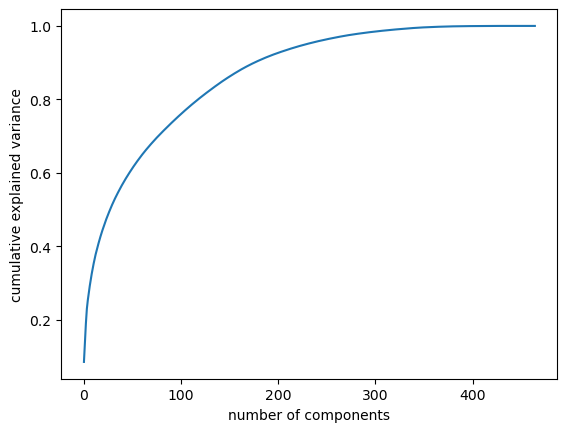

In [78]:
# Fit PCA object
pca = PCA().fit(azdias_trans)

# Plot scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
     

In [79]:
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

In [90]:
print('95% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.95].index[0]))

95% threshold of variance explained by 230 components.


In [80]:
# Reduce the azdias dataset
pca = PCA(n_components=230).fit(azdias_trans)
azdias_reduced = pca.transform(azdias_trans)
azdias_reduced = pd.DataFrame(azdias_reduced)
print(pca.explained_variance_ratio_.sum())

0.917086209218664


### Clustering with Elbow Method

In [81]:
inertia_scores = []
for num_clusters in range(1, 31):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    kmeans.fit(azdias_reduced.sample(20000))
    inertia_scores.append(kmeans.inertia_)

Text(0, 0.5, 'Average Within-Cluster Distances')

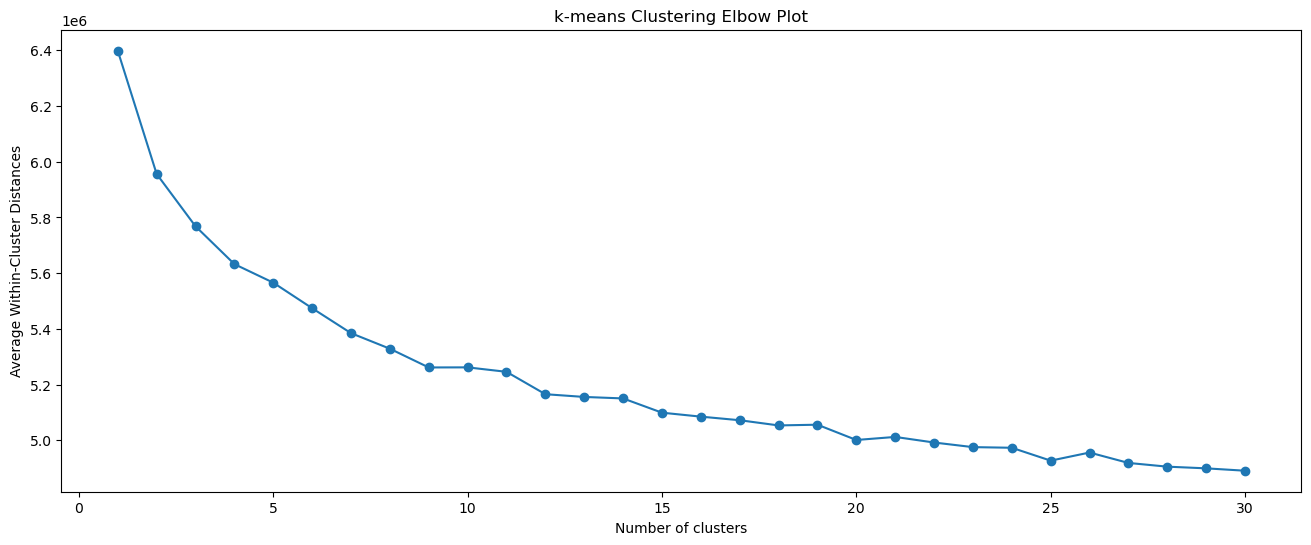

In [82]:
# Plot the Elbow plot to determine the optimal number of clusters
cluster_range = np.arange(1, 31)
plt.figure(figsize=(16, 6))
plt.plot(cluster_range, inertia_scores, '-o')
plt.title('K-means Clustering Elbow Plot')
plt.xlabel("Number of Clusters")
plt.ylabel("Average Within-Cluster Distances")
plt.show()

In [83]:
# Define a pipeline for clustering
clustering_pipeline = Pipeline([
    ('transform', column_transformer),
    ('reduce', PCA(n_components=192)),
    ('cluster', KMeans(n_clusters=12, init='k-means++'))
])

In [84]:
# Fit the pipeline and predict clusters for the azdias_clean dataset
clustering_pipeline.fit(azdias_clean)
azdias_clustered = pd.DataFrame(clustering_pipeline.predict(azdias_clean), columns=['Cluster'])

# Predict clusters for the customers_clean dataset
customers_clustered = pd.DataFrame(clustering_pipeline.predict(customers_clean), columns=['Cluster'])

In [86]:
# Save custered datasets to pickle files
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')

In [88]:
# Count the number of occurrences of each cluster in both datasets
population_cluster_counts = azdias_clustered["Cluster"].value_counts().sort_index()
customer_cluster_counts = customers_clustered["Cluster"].value_counts().sort_index()

In [89]:
# Combine the cluster counts into a single dataframe
cluster_comparison = pd.concat([population_cluster_counts, customer_cluster_counts], axis=1).reset_index()
cluster_comparison.columns = ['Cluster', 'Population', 'Customers']
# Calculate the percentage difference between the customer and population clusters
cluster_comparison['Difference'] = (cluster_comparison['Customers'] / cluster_comparison['Customers'].sum() * 100) - (cluster_comparison['Population'] / cluster_comparison['Population'].sum() * 100)
cluster_comparison

,cluster,population,customers,difference
0,0,68206,36883,18.220597
1,1,81168,13274,-1.514705
2,2,92557,27319,7.502816
3,3,61845,757,-8.243422
4,4,29350,4161,-1.031714
5,5,41034,5129,-1.964044
6,6,50599,2875,-5.035427
7,7,92623,1067,-12.396431
8,8,54464,24012,10.428014
9,9,36153,3763,-2.303132


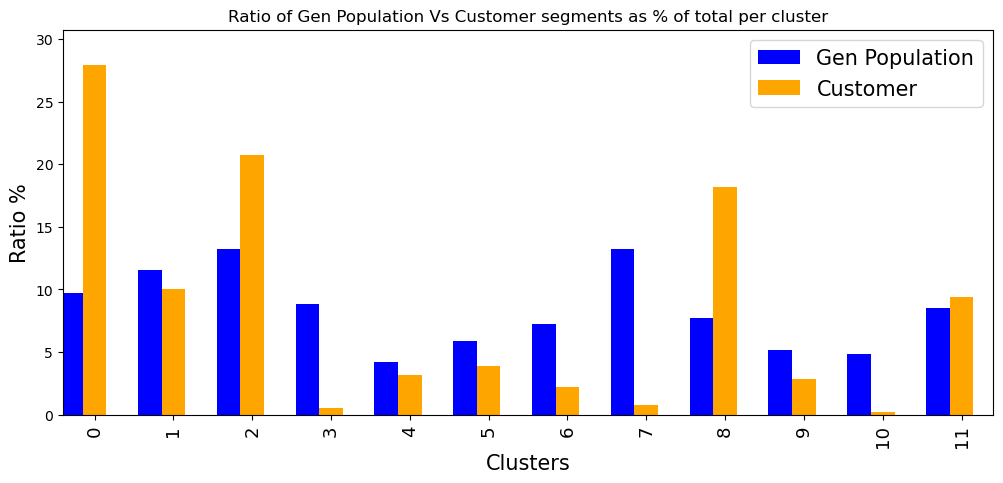

In [91]:
# Calculate the percentage representation of each cluster
clusters['population_percentage'] = (clusters['population'] / clusters['population'].sum() * 100).round(2)
clusters['customers_percentage'] = (clusters['customers'] / clusters['customers'].sum() * 100).round(2)

# Plot the cluster percentages
plt.figure(figsize=(12, 5))

ax = clusters['population_percentage'].plot(kind='bar', color='blue', width=-0.3, align='edge', position=0, label='General Population')
clusters['customers_percentage'].plot(kind='bar', color='orange', width=0.3, align='edge', position=1, label='Customers')

ax.set_xlabel('Clusters', fontsize=15)
ax.set_ylabel('Percentage (%)', fontsize=15)
ax.set_xticks(range(len(clusters)))
ax.set_xticklabels(clusters['cluster'], rotation=0)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.margins(x=0.05, y=0.1)

plt.legend(fontsize=15)
plt.title('Percentage of General Population vs Customer Segments per Cluster', fontsize=15)
plt.show()

In [92]:
# Calculate the explained variance ratio and principal component weights
explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance'])
explained_variance = explained_variance.round(3)

component_weights = pd.DataFrame(pca.components_, columns=azdias_transformed_df.columns)
component_weights = component_weights.round(3)

# Combine the explained variance ratios and component weights into a single DataFrame
pca_results = pd.concat([explained_variance, component_weights], axis=1)


In [93]:
# Show highest positive and negative weights for cluster 0
print("Highest Positive weights:")
print(result.iloc[0].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[0].sort_values()[:5])

Highest Positive weights:
(MOBI_REGIO,)        0.138
(PLZ8_ANTG1,)        0.131
(KBA13_ANTG1,)       0.130
(LP_STATUS_FEIN,)    0.129
(KBA05_ANTG1,)       0.128
Name: 0, dtype: float64


Negative weights:
(ANZ_HAUSHALTE_AKTIV,)   -0.131
(KBA13_ANTG3,)           -0.130
(PLZ8_ANTG3,)            -0.130
(KBA13_ANTG4,)           -0.126
(KBA13_BAUMAX,)          -0.125
Name: 0, dtype: float64


In [94]:
# Show highest positive and negative weights for cluster 6
print("Highest Positive weights:")
print(result.iloc[6].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[6].sort_values()[:5])

Highest Positive weights:
(SEMIO_VERT,)    0.315
(SEMIO_FAM,)     0.282
(SEMIO_KULT,)    0.281
(SEMIO_SOZ,)     0.266
(SEMIO_REL,)     0.176
Name: 6, dtype: float64


Negative weights:
(SEMIO_KAEM,)   -0.319
(SEMIO_DOM,)    -0.294
(SEMIO_KRIT,)   -0.265
(SEMIO_ERL,)    -0.248
(ANREDE_KZ,)    -0.167
Name: 6, dtype: float64


In [95]:
# Show highest positive and negative weights for cluster 1
print("Highest Positive weights:")
print(result.iloc[1].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[1].sort_values()[:5])

Highest Positive weights:
(PRAEGENDE_JUGENDJAHRE,)    0.160
(ONLINE_AFFINITAET,)        0.155
(CJT_TYP_2,)                0.154
(CJT_TYP_1,)                0.153
(FINANZ_SPARER,)            0.153
Name: 1, dtype: float64


Negative weights:
(CJT_TYP_5,)          -0.144
(FINANZ_VORSORGER,)   -0.143
(CJT_TYP_4,)          -0.140
(CJT_TYP_6,)          -0.136
(CJT_TYP_3,)          -0.134
Name: 1, dtype: float64


In [96]:
# Show highest positive and negative weights for cluster 4
print("Highest Positive weights:")
print(result.iloc[4].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[4].sort_values()[:5])

Highest Positive weights:
(KBA13_KW_61_120,)        0.194
(KBA13_KMH_210,)          0.180
(KBA13_CCM_1401_2500,)    0.157
(KBA13_VORB_0,)           0.153
(KBA13_SITZE_5,)          0.148
Name: 4, dtype: float64


Negative weights:
(KBA13_KW_0_60,)      -0.194
(KBA13_BJ_2000,)      -0.177
(KBA13_CCM_0_1400,)   -0.158
(KBA13_KMH_140,)      -0.157
(KBA13_KMH_0_140,)    -0.147
Name: 4, dtype: float64


In [97]:
# Extract components from the clustering pipeline
pca_transformer = cluster_pipeline.named_steps['reduce']
kmeans_model = cluster_pipeline.named_steps['cluster']
column_transformer = cluster_pipeline.named_steps['transform']

# Inverse transform the cluster centers to the original feature space
cluster_centers = pca_transformer.inverse_transform(kmeans_model.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=all_column_names)

# Extract and apply inverse transformations for numerical and skewed features
numerical_scaler = column_transformer.named_transformers_['numerical'].named_steps['scale_standard']
skewed_scaler = column_transformer.named_transformers_['skewed'].named_steps['scale_standard']
skewed_transformer = column_transformer.named_transformers_['skewed'].named_steps['log_transform']

cluster_centers_df[numeric_columns] = numerical_scaler.inverse_transform(cluster_centers_df[numeric_columns])
cluster_centers_df[skewed_columns] = skewed_scaler.inverse_transform(cluster_centers_df[skewed_columns])
cluster_centers_df[skewed_columns] = skewed_transformer.inverse_transform(cluster_centers_df[skewed_columns])

# Select and compare specific clusters
comparison_df = cluster_centers_df.T[[0, 6, 1, 4]]
comparison_df.columns = ['interested_cluster_0', 'interested_cluster_6', 'not_interested_cluster_1', 'not_interested_cluster_4']

# Filter features with a standard deviation greater than 2
filtered_comparison_df = comparison_df[comparison_df.std(axis=1) > 2]
filtered_comparison_df


,interested_cluster_0,interested_cluster_6,not_interested_cluster_1,not_interested_cluster_4
D19_GESAMT_DATUM,3.445103,3.074786,8.426930,2.162423
LP_LEBENSPHASE_GROB,8.514101,5.220519,3.319662,7.497971
D19_VERSAND_DATUM,4.029389,3.932292,9.058870,4.407987
GEMEINDETYP,24.422082,16.559838,18.232212,27.607605
D19_BANKEN_DATUM,8.986918,8.136550,9.787354,3.312747
EINGEZOGENAM_HH_JAHR,2000.553230,2007.833401,2002.130276,2004.099514
ANZ_STATISTISCHE_HAUSHALTE,2.187728,10.956883,11.405008,3.393493
VK_DISTANZ,4.036749,5.682102,9.005917,4.577196
GEBURTSJAHR,1533.198230,1712.064602,964.352899,1670.623378
D19_VERSAND_ONLINE_DATUM,4.529274,4.024261,9.310057,4.651025


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train = pd.read_pickle('mailout_train.pkl')
mailout_test = pd.read_pickle('mailout_test.pkl')

In [99]:
mailout_train.info

<bound method DataFrame.info of          LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       1763         2         1.0       8.0          NaN          NaN   
1       1771         1         4.0      13.0          NaN          NaN   
2       1776         1         1.0       9.0          NaN          NaN   
3       1460         2         1.0       6.0          NaN          NaN   
4       1783         2         1.0       9.0          NaN          NaN   
...      ...       ...         ...       ...          ...          ...   
42957  66338         2         1.0       0.0          NaN          NaN   
42958  67629        -1         1.0       0.0          NaN          NaN   
42959  68273         1         1.0      16.0          NaN          NaN   
42960  68581         2         1.0      18.0          NaN          NaN   
42961  69224         2         1.0      13.0          NaN          NaN   

       ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0

In [101]:
# Clean the mailout_train dataset
# Remove columns with high percentages of missing values
cleaned_mailout_train = mailout_train.drop(columns=drop_null_cols)

# Convert 'EINGEFUEGT_AM' to datetime and extract the year
cleaned_mailout_train['EINGEFUEGT_AM'] = pd.to_datetime(cleaned_mailout_train['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S').dt.year

# Replace 'O' with 0 and 'W' with 1 in the 'OST_WEST_KZ' column
cleaned_mailout_train['OST_WEST_KZ'] = cleaned_mailout_train['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
cleaned_mailout_train['OST_WEST_KZ'] = pd.to_numeric(cleaned_mailout_train['OST_WEST_KZ'], errors='coerce')

# Remove rows with more than 11 missing values and reset the index
cleaned_mailout_train = cleaned_mailout_train[cleaned_mailout_train.isnull().sum(axis=1) <= 11].reset_index(drop=True)

# Print the number of rows in the cleaned dataset
print('Number of rows in the cleaned dataset:', cleaned_mailout_train.shape[0])


number of rows in new dataset:  33582


In [102]:
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

In [103]:
# Set models for testing prediction
model_dict = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

RandomForestClassifier
AUC train score = 1.0
AUC validation score = 0.62



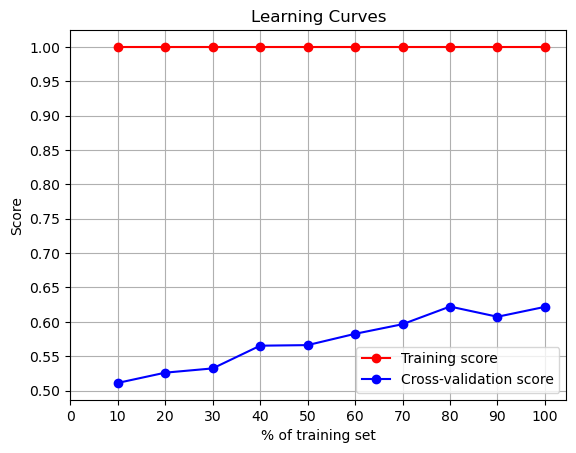

AdaBoostClassifier


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

AUC train score = 0.88
AUC validation score = 0.75



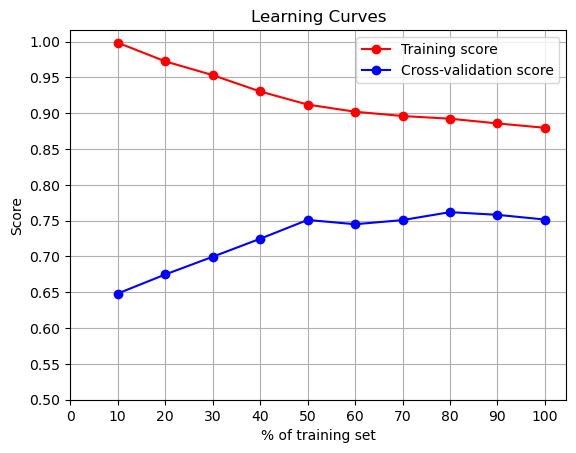

GradientBoostingClassifier
AUC train score = 0.96
AUC validation score = 0.78



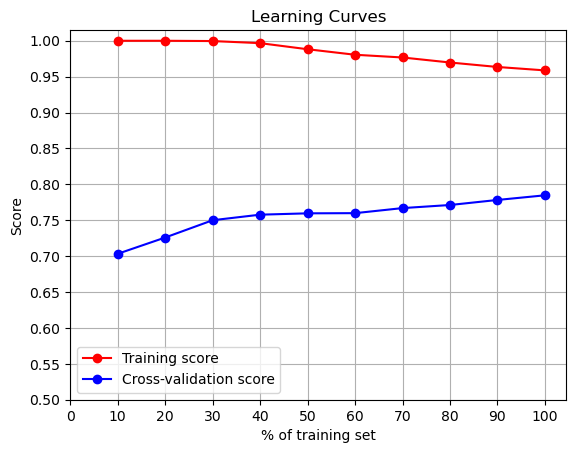

In [104]:
# Loop through each model and generate learning curves
for model_name, model in model_dict.items():
    print(model_name)
    
    # Create a pipeline with the column transformer and the model
    pipeline = Pipeline([
        ('transform', column_transformer),
        ('model', model)
    ])
    
    # Randomize the dataset
    randomized_data = mailout_train_clean.sample(frac=1)
    X_randomized = randomized_data.drop(columns=['RESPONSE'])
    y_randomized = randomized_data['RESPONSE']
    
    # Generate learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, X_randomized, y_randomized, scoring='roc_auc', train_sizes=np.linspace(.1, 1.0, 10)
    )
    
    # Calculate mean training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    print(f"AUC train score = {train_scores_mean[-1]:.2f}")
    print(f"AUC validation score = {test_scores_mean[-1]:.2f}")
    plt.grid()
    
    # Plot the learning curves
    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Percentage of Training Set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, 10) * 100, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(np.linspace(.1, 1.0, 10) * 100, test_scores_mean, 'o-', color="blue", label="Cross-validation score")

    plt.yticks(np.arange(0.50, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    plt.show()
    print("")

In [105]:
# Create a pipeline with a GradientBoostingClassifier
gradient_boosting_pipeline = Pipeline([
    ('transform', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'gbc__learning_rate': [0.1, 0.2],
    'gbc__n_estimators': [100],
    'gbc__max_depth': [3, 5],
    'gbc__min_samples_split': [2, 4]
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(gradient_boosting_pipeline, param_grid, scoring='roc_auc')

# Fit the grid search to the training data to find the best hyperparameters
grid_search_result = grid_search.fit(X, y)


In [106]:
# Retrieve the best parameters and make predictions
print("Best hyperparameters found by GridSearchCV:", grid_search_result.best_params_)
best_model = grid_search_result.best_estimator_
best_model_predictions = best_model.predict_proba(X)[:, 1]

# Make predictions using the initial unoptimized pipeline and the optimized best model
initial_model_predictions = gradient_boosting_pipeline.fit(X, y).predict_proba(X)[:, 1]

# Print ROC AUC scores for both models
print("ROC AUC score (initial model): {:.4f}".format(roc_auc_score(y, initial_model_predictions)))
print("ROC AUC score (best model): {:.4f}".format(roc_auc_score(y, best_model_predictions)))

{'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__min_samples_split': 4, 'gbc__n_estimators': 100}
ROC score: 0.9444
Final ROC score: 0.9415


Text(0.5, 0, 'feature importance')

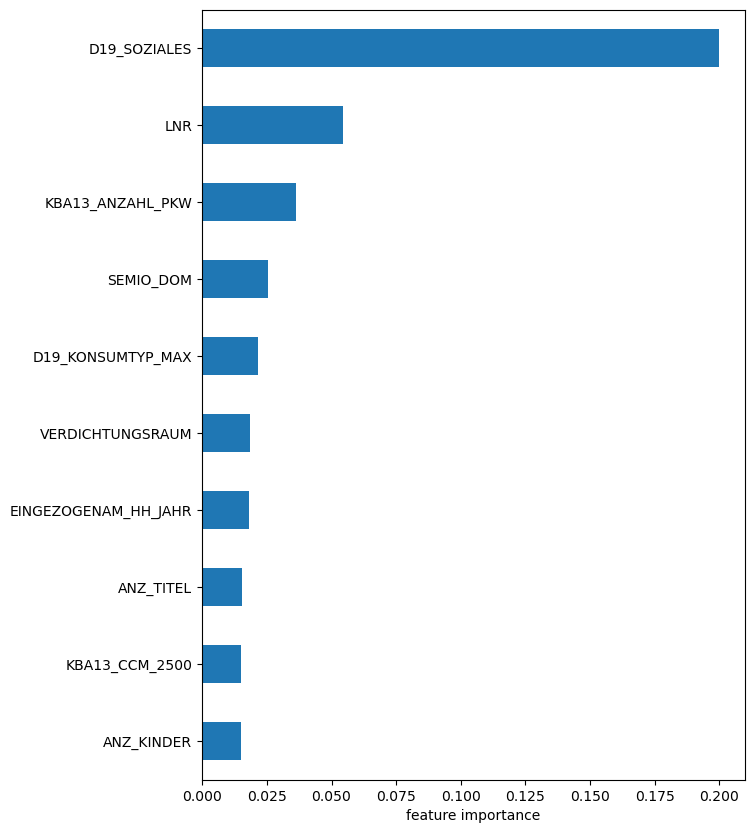

In [107]:
# Plot the feature importances of the best model
feature_importances = best_model.named_steps['gbc'].feature_importances_
pd.Series(feature_importances, index=all_column_names).sort_values().tail(10).plot(kind='barh', figsize=(7, 10))
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()